## Personal ML project - Diabetes prediction 

1. Our database: Diabetes 130-US Hospitals for Years 1999-2008
https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

# Number of instances
101766

# Associated Tasks
Classification, Clustering



In [ ]:
'''import pandas as pd
import zipfile
import requests
from io import BytesIO

# Download the zip file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as z:
    # Extract the main CSV file
    with z.open('dataset_diabetes/diabetic_data.csv') as f:
        diabetes = pd.read_csv(f)
diabetes.head()'''

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [102]:
# Load main prepared earlier
diabetes = pd.read_parquet("data/01_main.parquet")
print("data shape:", diabetes.head())


data shape:    encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... glyburide-metformin  glipizide-metformin  \
0                 1  ...                  No         

# Exploring the data 

- Histogram, boxplots and bar charts will be used to analyze the structure of the data 
- Check the feature distribution and evaluate what are the most related with diabetes 
- Check for the categories that posses an specific meaning 

In [103]:
print(diabetes.shape)
print(diabetes.columns)

(101763, 48)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'age_group', 'weight_group'],
      dtype='object')


In [104]:
# Do a train test split of the original training data
from sklearn.model_selection import train_test_split

diabetes_train, diabetes_test = train_test_split(diabetes, test_size=0.2, random_state=42)

print("Train data shape:", diabetes_train.shape)
print("Test data shape:", diabetes_test.shape)



Train data shape: (81410, 48)
Test data shape: (20353, 48)


## We will visualize the distributions and relevant relationships

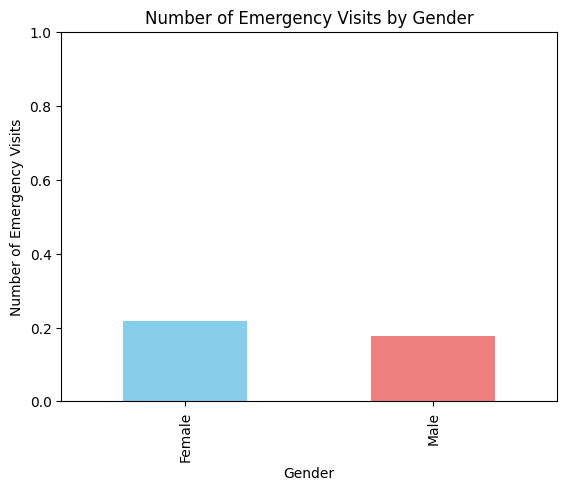

In [105]:
# Import necessary libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt


def plot_number_emergency_by_gender(df):
    number_emergency = df.groupby("gender")["number_emergency"].mean()
    number_emergency.plot(kind="bar", color=["skyblue", "lightcoral"])
    plt.title("Number of Emergency Visits by Gender")
    plt.ylabel("Number of Emergency Visits")
    plt.xlabel("Gender")
    plt.ylim(0, 1)
    plt.show()

plot_number_emergency_by_gender(diabetes_train)


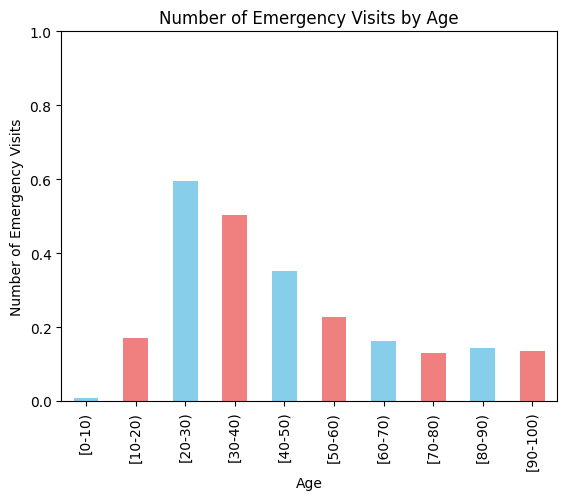

In [107]:
def plot_number_emergency_by_age(df):
    number_emergency = df.groupby("age")["number_emergency"].mean()
    number_emergency.plot(kind="bar", color=["skyblue", "lightcoral"])
    plt.title("Number of Emergency Visits by Age")
    plt.ylabel("Number of Emergency Visits")
    plt.xlabel("Age")
    plt.ylim(0, 1)
    plt.show()
plot_number_emergency_by_age(diabetes_train)

In [108]:
# Define a function to map age bins to new categories
def map_age_category(age_str):
    # Remove brackets and split by '-'
    age_str = age_str.strip('[]')
    start, end = age_str.split('-')
    start = int(start)
    end = int(end.replace(')', ''))
    if start < 30:
        return '0-30'
    elif start < 60:
        return '30-60'
    elif start < 90:
        return '60-90'
    else:
        return '90-120'

# Apply to diabetes_train and diabetes_train_clean
diabetes_train['age_group'] = diabetes_train['age'].apply(map_age_category)

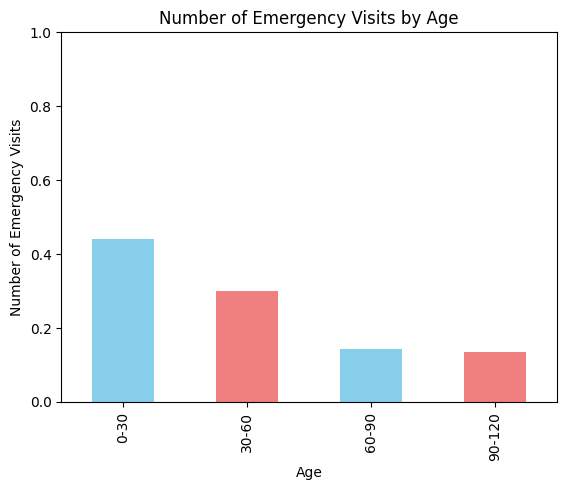

In [109]:
def plot_number_emergency_by_age(df):
    number_emergency = df.groupby("age_group")["number_emergency"].mean()
    number_emergency.plot(kind="bar", color=["skyblue", "lightcoral"])
    plt.title("Number of Emergency Visits by Age")
    plt.ylabel("Number of Emergency Visits")
    plt.xlabel("Age")
    plt.ylim(0, 1)
    plt.show()
plot_number_emergency_by_age(diabetes_train)

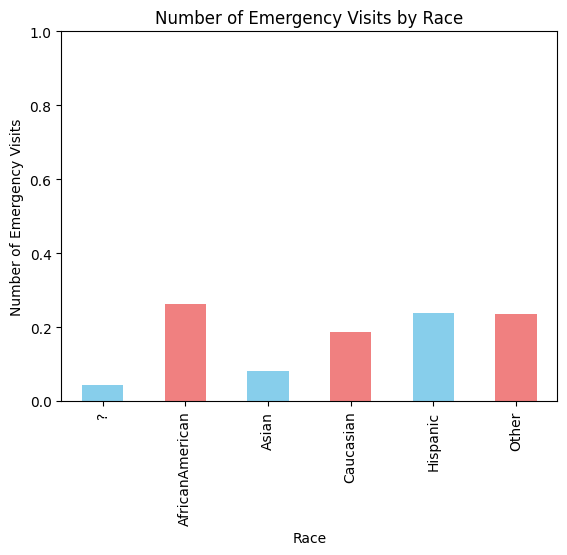

In [51]:
def plot_number_emergency_by_race(df):
    number_emergency = df.groupby("race")["number_emergency"].mean()
    number_emergency.plot(kind="bar", color=["skyblue", "lightcoral"])
    plt.title("Number of Emergency Visits by Race")
    plt.ylabel("Number of Emergency Visits")
    plt.xlabel("Race")
    plt.ylim(0, 1)
    plt.show()
plot_number_emergency_by_race(diabetes_train)

race_group
Caucasian          60898
AfricanAmerican    15355
Other               3005
Hispanic            1628
Asian                524
Name: count, dtype: int64


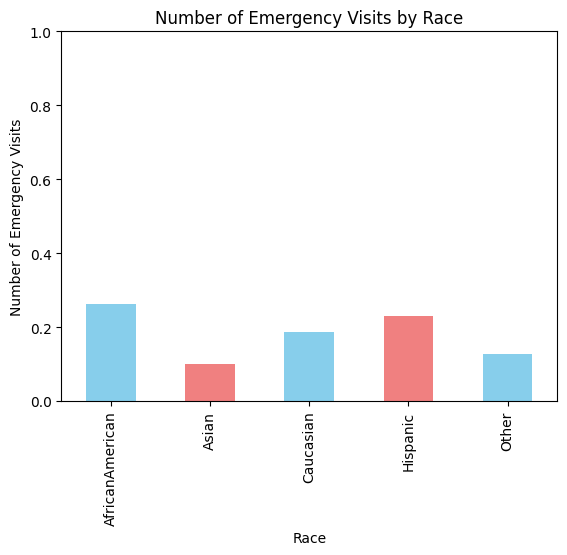

In [110]:
# Combine 'Other' and '?' categories in the 'race' column of diabetes_train and save as 'race_group'
diabetes_train['race_group'] = diabetes_train['race'].replace('?', 'Other')
print(diabetes_train['race_group'].value_counts())

def plot_number_emergency_by_race(df):
    number_emergency = df.groupby("race_group")["number_emergency"].mean()
    number_emergency.plot(kind="bar", color=["skyblue", "lightcoral"])
    plt.title("Number of Emergency Visits by Race")
    plt.ylabel("Number of Emergency Visits")
    plt.xlabel("Race")
    plt.ylim(0, 1)
    plt.show()
plot_number_emergency_by_race(diabetes_train)

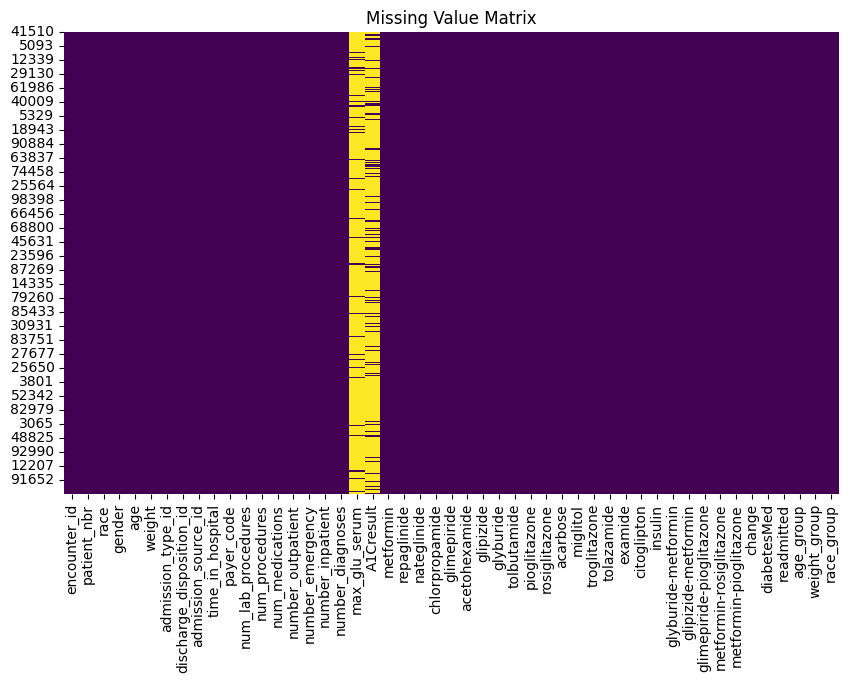

In [111]:
def plot_missing_value_matrix(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    plt.title("Missing Value Matrix")
    plt.show()

plot_missing_value_matrix(diabetes_train)

## Drop 2 of the columns that have missing information for sure 
**Completely excluded them because the missing values are too abundant**
- max_glu_serum
- A1Cresult

**Excluded because I want to make a basing model first later we can integrate them if the performance of the model is not proper**

- Payer_code
- medical_speciality 
- diag_1, diag_2, diag_3

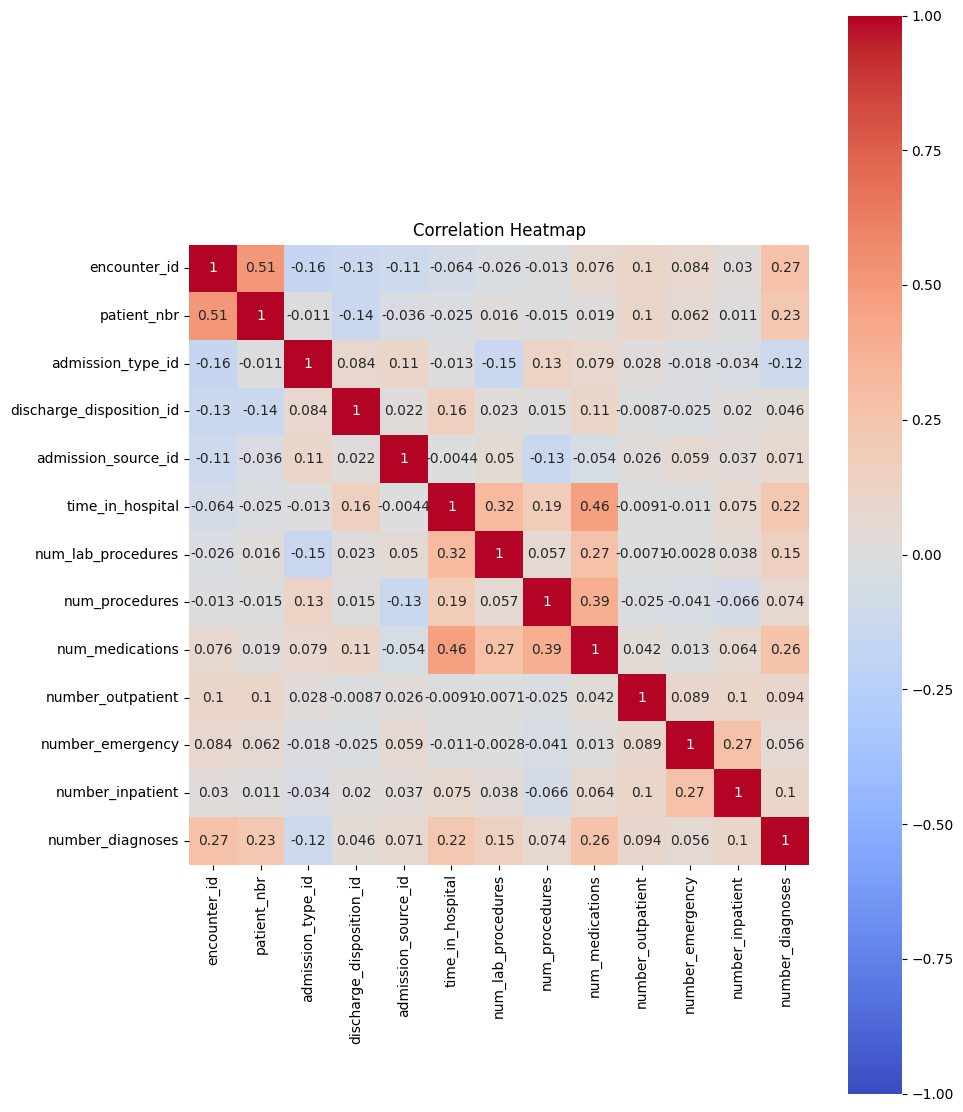

In [112]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df):
    # keep only the columns we want, if they exist
    cols = df.select_dtypes(include=['number']).columns

    # coerce to numeric in case 'age' is stored as strings/bins
    data = df[cols].apply(pd.to_numeric, errors='coerce')

    plt.figure(figsize=(10, 14))  # set size BEFORE plotting
    ax = sns.heatmap(data.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True)
    ax.set_title("Correlation Heatmap")
    plt.show()

# call
plot_correlation_heatmap(diabetes_train)


In [114]:
#So from the training data, we can see that the columns 'max_glu_serum', 'A1Cresult', 'Payer_code', 'medical_speciality',
# 'diag_1', 'diag_2', and 'diag_3' have a lot of missing values, so I want to remove them from the training data 

cols_to_drop = ['max_glu_serum', 'A1Cresult', 'payer_code']
diabetes_train_clean = diabetes_train.drop(columns=cols_to_drop)
diabetes_train_clean.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_group,weight_group,race_group
41510,128413584,23279256,Caucasian,Male,[70-80),?,1,22,7,2,...,No,No,No,No,Ch,Yes,NO,60-90,Normal,Caucasian
24079,81844290,94788,Caucasian,Female,[70-80),?,1,1,7,4,...,No,No,No,No,No,No,NO,60-90,Normal,Caucasian
91367,308424104,45904869,AfricanAmerican,Female,[40-50),?,1,1,7,2,...,No,No,No,No,No,Yes,>30,30-60,Normal,AfricanAmerican
6237,31258956,18397782,Caucasian,Male,[80-90),?,1,1,7,4,...,No,No,No,No,No,Yes,NO,60-90,Normal,Caucasian
72207,210691074,67509558,Caucasian,Male,[80-90),?,1,3,7,3,...,No,No,No,No,Ch,Yes,NO,60-90,Normal,Caucasian


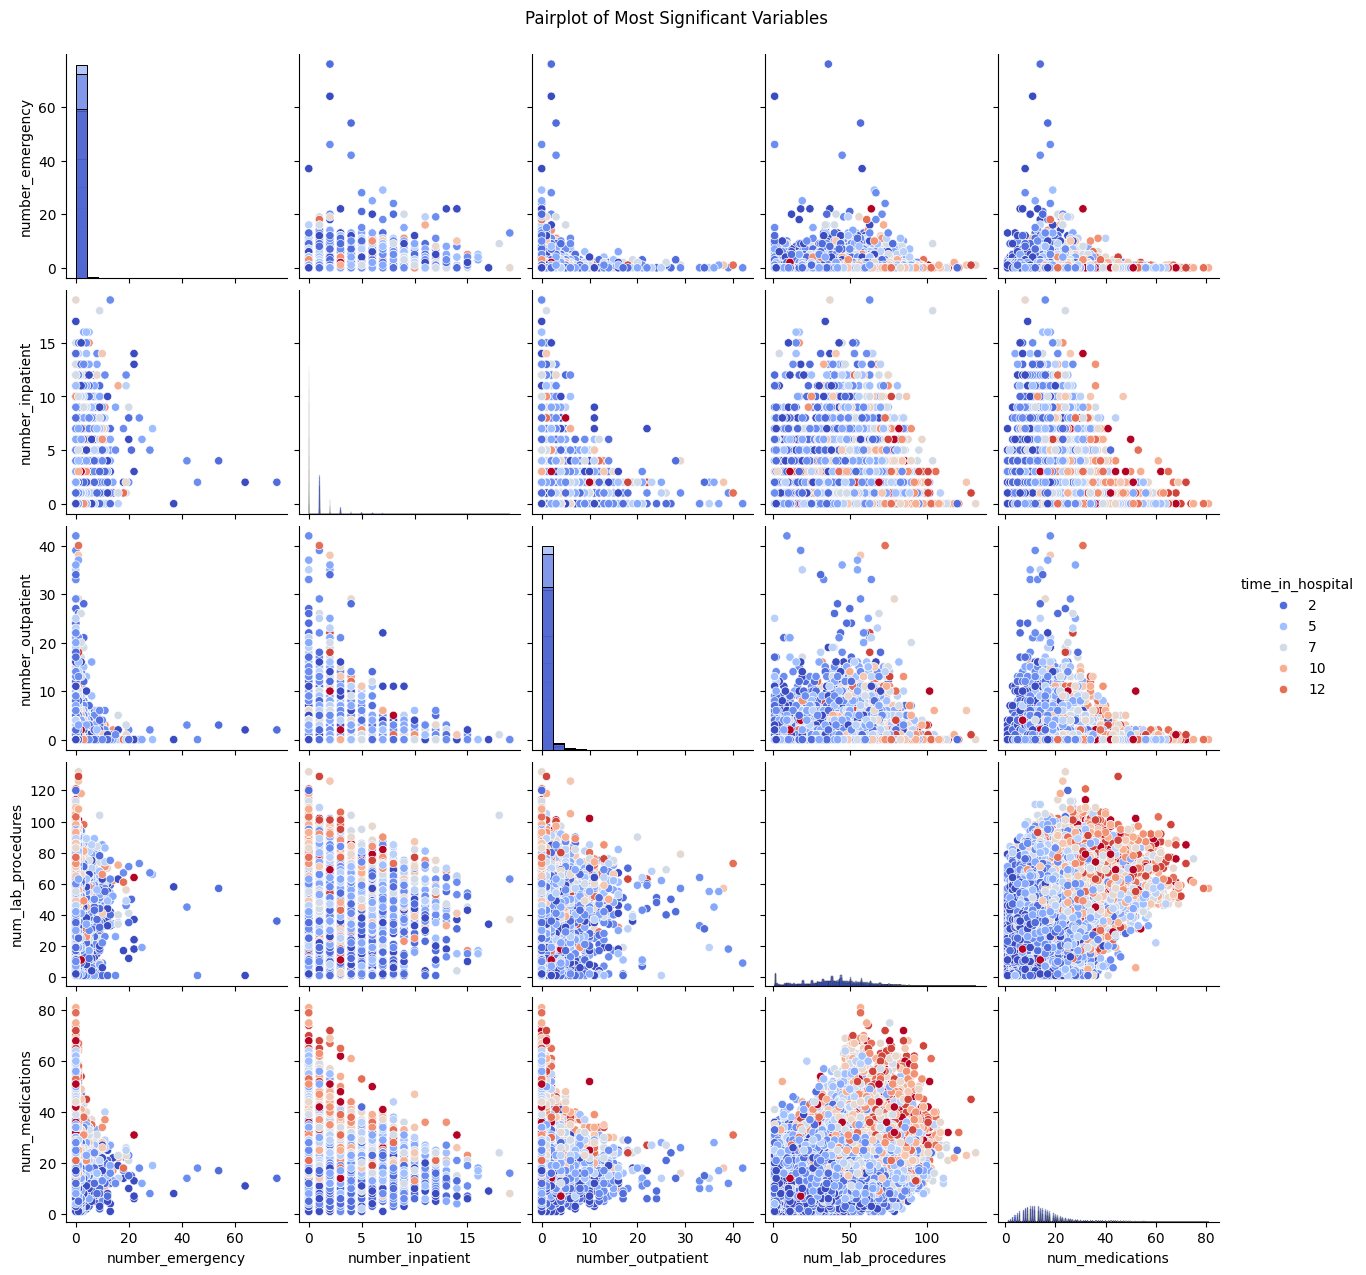

In [115]:
# Select columns that are likely to be most significant for diabetes/emergency visits
# We'll include some numeric features and the encoded categorical columns
important_cols = [
    'number_emergency', 
    'number_inpatient',
    'number_outpatient',
    'num_lab_procedures',
    'num_medications',
    'time_in_hospital',
    'age_group',
    'race_group',
    'gender'
]

# Filter to only columns that exist in encoded_df
pairplot_cols = [col for col in important_cols if col in diabetes_train_clean.columns]

sns.pairplot(diabetes_train_clean[pairplot_cols], hue='time_in_hospital', diag_kind='hist', palette='coolwarm')
plt.suptitle("Pairplot of Most Significant Variables", y=1.02)
plt.show()

## Classificator


- I want my classificator to predict how many days my diabetic patients have been hospitalized base on the data set to predict the time_in_hospital accurately, to keep working with this dataset we will have to 

/var/folders/zn/168nw9p56h9_1x_smvw9yfcr0000gn/T/ipykernel_27164/2357845742.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='age_group', data=df, ax=axes[0], palette="Blues")
/var/folders/zn/168nw9p56h9_1x_smvw9yfcr0000gn/T/ipykernel_27164/2357845742.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='race_group', data=df, ax=axes[1], palette="Oranges")


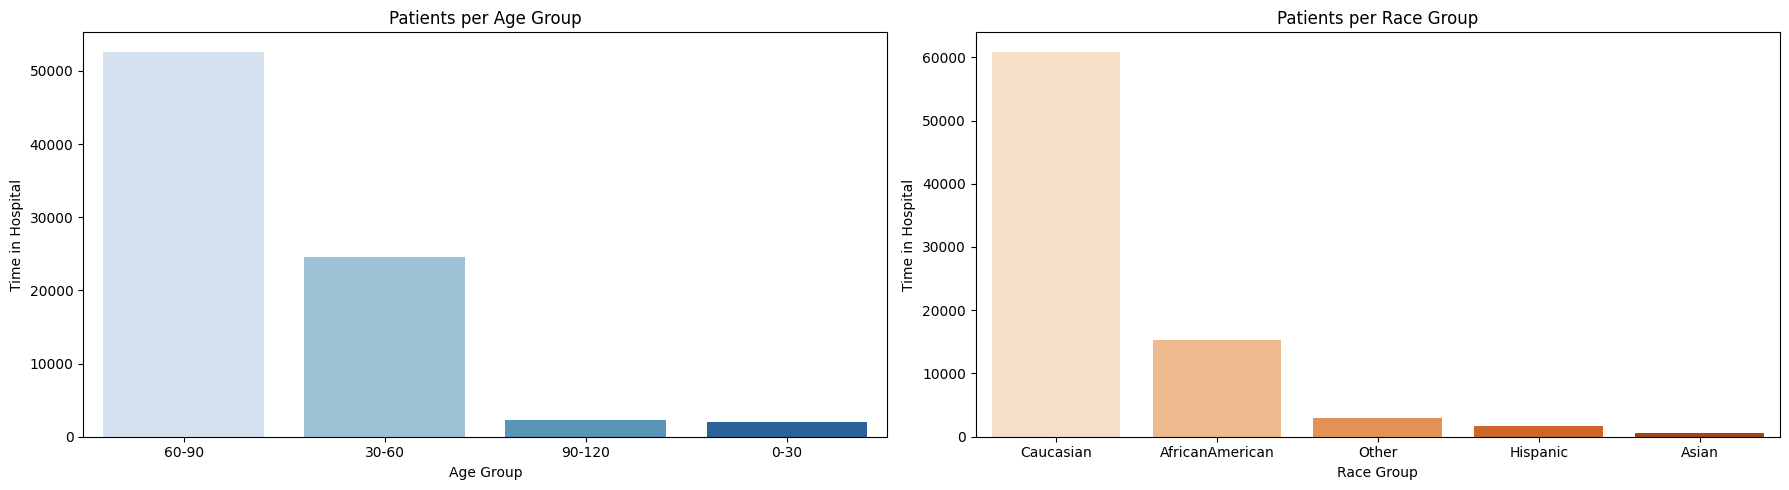

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

df = diabetes_train.dropna(
    subset=['time_in_hospital', 'age_group', 'weight_group', 'race_group']
).copy()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Age group distribution
sns.countplot(x='age_group', data=df, ax=axes[0], palette="Blues")
axes[0].set_title("Patients per Age Group")
axes[0].set_xlabel("Age Group")
axes[0].set_ylabel("Time in Hospital")

# Race group distribution
sns.countplot(x='race_group', data=df, ax=axes[1], palette="Oranges")
axes[1].set_title("Patients per Race Group")
axes[1].set_xlabel("Race Group")
axes[1].set_ylabel("Time in Hospital")

plt.tight_layout()
plt.show()


In [120]:
diabetes_train.to_parquet("data/02_train.parquet", index=False)
diabetes_test.to_parquet("data/02_test.parquet", index=False)